In [183]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import pennylane as qml
from pennylane import expval

In [184]:
dev = qml.device("default.qubit", wires=2)

In [185]:
alpha = 0.4
beta = 0.2

coeffs = [alpha, alpha, beta]
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

In [186]:
def circuit(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    
    qml.CNOT(wires=wires)
    
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])

In [187]:
qnodes = qml.map(circuit, obs_list, dev, measure='expval')
energy_expval = qml.dot([alpha, alpha, beta], qnodes)

Number of VQE runs

In [188]:
k_runs = 10 

In [189]:
step_size = 0.3
max_iterations = 50

Here, we don't terminate based on energy improvement but run a fixed number of steps (50 in this case). 

In [190]:
# List to store energy histories for all the VQE runs
energy_history = []

for k in range(k_runs):

    # Energy history for a single VQE run
    energy_history_single_run = []
    
    # Randomly initialize parameters
    initial_params = np.random.uniform(low=0, high=2*np.pi, size=4).tolist()
    #print(initial_params)

    params = initial_params
    prev_energy = energy_expval(params)
    energy_history_single_run.append(prev_energy)

    for n in range(max_iterations):

        grad_cost = qml.grad(energy_expval, argnum=[0])
        grad_at_point = [float(i) for i in grad_cost(params)[0]] 

        params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params])),
                                             grad_at_point)

        energy = energy_expval(params)

        conv = np.abs(energy - prev_energy)

        prev_energy = energy
        energy_history_single_run.append(prev_energy)
        
    print('Finished run #{}'.format(k))

    energy_history_single_run = np.array(energy_history_single_run)
    #print(energy_history_single_run)
    energy_history.append(energy_history_single_run)
    #print(energy_history)

Finished run #0
Finished run #1
Finished run #2
Finished run #3
Finished run #4
Finished run #5
Finished run #6
Finished run #7
Finished run #8
Finished run #9


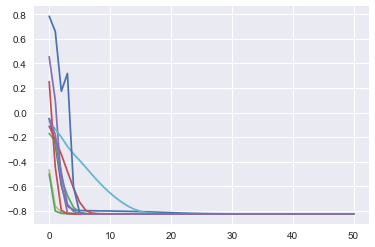

In [191]:
for i in range(k_runs):
    plt.plot(energy_history[i])

For plotting standard deviations, check out this Stackoverflow response:

https://datascience.stackexchange.com/questions/30913/plots-with-shaded-standard-deviation

Check out the documentation for `fill_between()` in matplotlib.

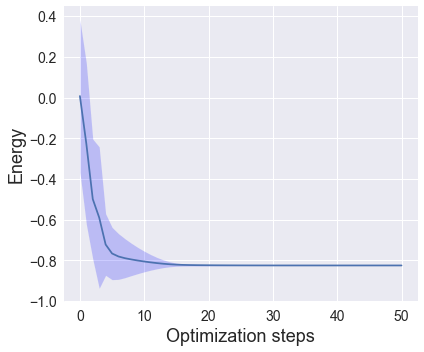

In [192]:
%matplotlib inline
plt.style.use("seaborn")
fig = plt.figure(figsize=(6, 5))

###    PLOTTING STD   ####

#needs to be an array for .mean() and .std() to work for some reason
energy_hist = np.asarray(energy_history)

#x values (optimization steps)
x = np.arange(max_iterations+1)

#calc standard dev. and mean
std = energy_hist.std(axis=0)
mean = energy_hist.mean(axis=0)

#plot mean for reference
plt.plot(mean)

#plot x values, and fill to +- standard dev
plt.fill_between(x, mean-std, mean+std, facecolor='blue', alpha=0.2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)

plt.tight_layout()
plt.show()